## Prepare training data

In [9]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.preprocessing import MultiLabelBinarizer
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

FAST_RUN = False

EPOCHS=1000
BATCH_SIZE = 128
TARGET_SIZE = (180, 180)
THRESHOLD = 0.50
INPUT_PATH = "./kaggle/input/plant-pathology-2021-fgvc8/"
CHECKPOINT_FILEPATH = './tmp/checkpoint'
MODEL_FILEPATH = './model'
CLASS_NAMES = ['complex', 'frog_eye_leaf_spot', 'healthy', 'powdery_mildew', 'rust', 'scab']
NUM_CLASSES = len(CLASS_NAMES)

def labels_to_str(vector):
    result = []
    for idx, v in enumerate(vector):
        if v == 1:
            result.append(CLASS_NAMES[idx])
    return " ".join(result)


print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [10]:
train = pd.read_csv(INPUT_PATH+ '/train.csv')
train.head()

mlb = MultiLabelBinarizer().fit(train.labels.apply(lambda x : x.split()))
labels = pd.DataFrame(mlb.transform(train.labels.apply(lambda x : x.split())), columns = mlb.classes_)

labels = pd.concat([train['image'], labels], axis=1)
labels.head()

,image,complex,frog_eye_leaf_spot,healthy,powdery_mildew,rust,scab
0,800113bb65efe69e.jpg,0,0,1,0,0,0
1,8002cb321f8bfcdf.jpg,1,1,0,0,0,1
2,80070f7fb5e2ccaa.jpg,0,0,0,0,0,1
3,80077517781fb94f.jpg,0,0,0,0,0,1
4,800cbf0ff87721f8.jpg,1,0,0,0,0,0


## Load training data

In [11]:
img_gen = ImageDataGenerator(
    rescale=1/255,
    validation_split=0.2
)

train_ds = img_gen.flow_from_dataframe(
    labels,
    directory=INPUT_PATH+"train_images",
    # save_to_dir=INPUT_PATH+"train_images_augmented",
    shuffle=True,
    class_mode="raw",
    color_mode="rgb",
    x_col='image',
    y_col=labels.columns.tolist()[1:],
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    subset='training',
    seed=123
)

val_ds = img_gen.flow_from_dataframe(
    labels,
    directory=INPUT_PATH+"train_images",
    # save_to_dir=INPUT_PATH+"val_images_augmented",
    shuffle=True,
    class_mode="raw",
    color_mode="rgb",
    x_col='image',
    y_col=labels.columns.tolist()[1:],
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    subset='validation',
    seed=123
)

Found 14906 validated image filenames.
Found 3726 validated image filenames.


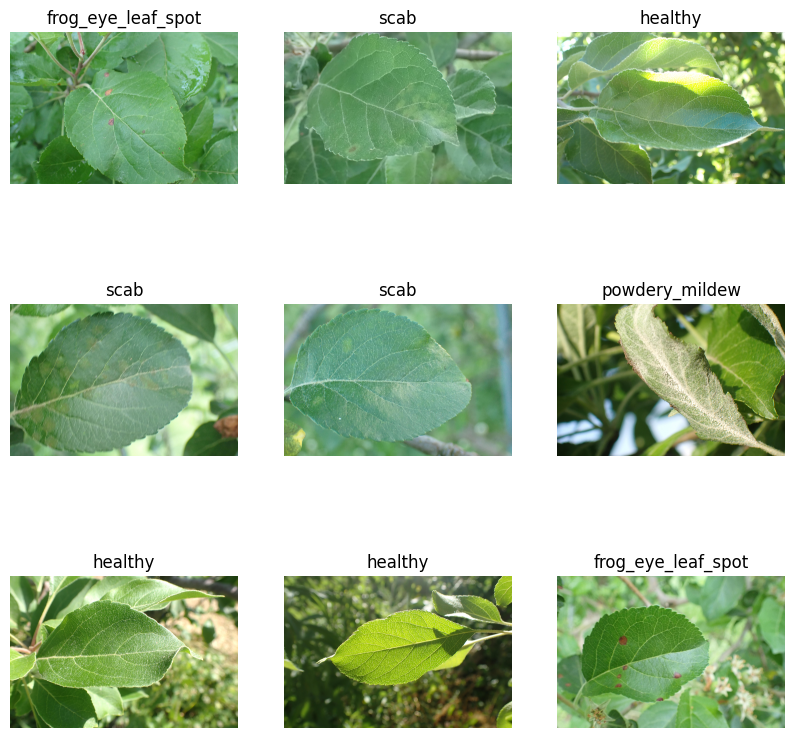

In [12]:
def load_image( infilename ) :
    img = Image.open( infilename )
    img.load()
    data = np.asarray( img, dtype="int32" )
    return data

plt.figure(figsize=(10, 10))
for i, (image,labels) in enumerate(zip(train_ds.filepaths[:9],train_ds.labels[:9])):
    image = load_image(image)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.astype("uint8"))
    plt.title(labels_to_str(labels))
    plt.axis("off")

In [13]:
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(NUM_CLASSES, activation='sigmoid')
])
model.compile(
  loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"]
  )
model.build(input_shape=(None, 180, 180, 3))

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 87, 87, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 41, 41, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 20, 20, 32)      

## Train data

In [14]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  workers=8,
  epochs=EPOCHS,
  callbacks = [tf.keras.callbacks.ModelCheckpoint(
                CHECKPOINT_FILEPATH, 
                save_weights_only=True,
                monitor='val_loss',
                mode='max',
                save_best_only=True,
                verbose=1),
              tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0.001, patience=10,verbose=1),
              tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.1,
                patience=6,
                verbose=0,
                mode='auto',
                min_delta=0.001,
                cooldown=0,
                min_lr=1e-9,
            )
            ],
  verbose=1
)

model.load_weights(CHECKPOINT_FILEPATH) 
model.save(MODEL_FILEPATH)

Epoch 1/1000
117/117 [==============================] - ETA: 0s - loss: 0.4212 - accuracy: 0.3425
Epoch 1: val_loss improved from -inf to 0.40397, saving model to ./tmp\checkpoint
117/117 [==============================] - 216s 2s/step - loss: 0.4212 - accuracy: 0.3425 - val_loss: 0.4040 - val_accuracy: 0.4082 - lr: 0.0010
Epoch 2/1000
 96/117 [=======================>......] - ETA: 26s - loss: 0.3665 - accuracy: 0.4759

In [ ]:
model = tf.keras.models.load_model(MODEL_FILEPATH)

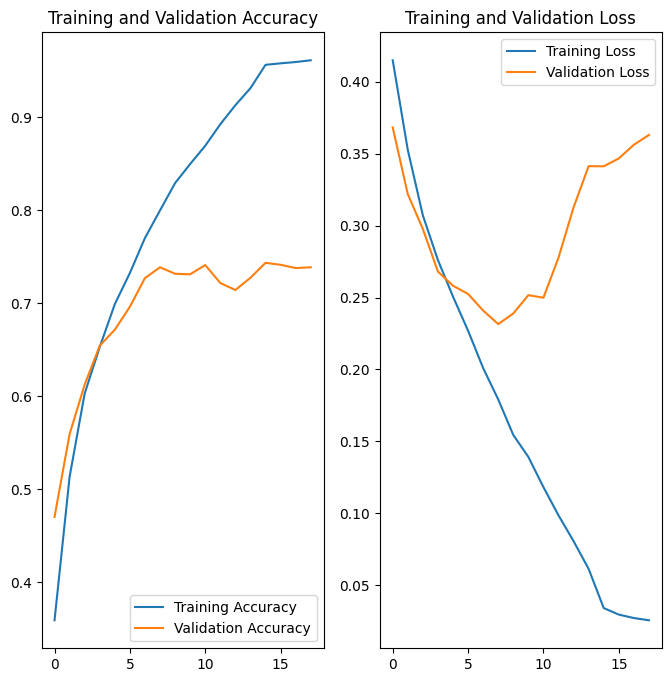

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))


plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
predicted_val_labels = model.predict(val_ds)
print("Validataion metrics")
print(predicted_val_labels)

30/30 [==============================] - 162s 5s/step
Validataion metrics


In [ ]:
predicted = (predicted_val_labels > THRESHOLD).astype(int)
print(classification_report(val_ds.labels,predicted))

              precision    recall  f1-score   support

           0       0.09      0.02      0.03       385
           1       0.33      0.00      0.01       729
           2       0.21      0.10      0.14       814
           3       0.17      0.02      0.04       357
           4       0.12      0.03      0.05       435
           5       0.35      0.26      0.30      1241

   micro avg       0.28      0.11      0.16      3961
   macro avg       0.21      0.07      0.09      3961
weighted avg       0.25      0.11      0.14      3961
 samples avg       0.12      0.11      0.11      3961

validation mean f1-score: 0.09302166888062115


c:\repos\nasdaq_classifying\.venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\repos\nasdaq_classifying\.venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Test prediction

In [ ]:
test_df = pd.read_csv(INPUT_PATH + 'sample_submission.csv')
test_path = INPUT_PATH + 'test_images'

image_test_datagen = ImageDataGenerator(
    rescale=1./255,
)

test_generator = image_test_datagen.flow_from_dataframe(
    test_df,
    directory = test_path,
    x_col = "image",
    y_col = "labels",
    target_size = TARGET_SIZE,
    color_mode="rgb",
    batch_size=1,
    shuffle=False,
    seed=123,
    subset=None
)

Found 3 validated image filenames belonging to 1 classes.


In [ ]:
predicts = model.predict(test_generator)
verdict = (predicts>THRESHOLD)
answer = []
for i in range(verdict.shape[0]):
    answer.append(labels_to_str(verdict[i]))


test_df['labels'] = np.array(answer)
print(test_df)
test_df.to_csv('submission.csv', index=False)

3/3 [==============================] - 0s 70ms/step
                  image labels
0  85f8cb619c66b863.jpg   rust
1  ad8770db05586b59.jpg       
2  c7b03e718489f3ca.jpg       
